In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import math
import cartopy.crs as crs

### Understanding Principal Component Analysis

In [2]:
def PCA_n(X, num_components):

    X_meaned = X - np.mean(X, axis = 0)
    X_meaned /= np.std(X_meaned, axis=0) 
    #cov_mat = np.cov(X_meaned, rowvar = False)
    cov_mat = X_meaned.T @ X_meaned / (X_meaned.shape[0] - 1)
     
    #eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    eigen_vectors, eigen_values, _ = np.linalg.svd(cov_mat)
    
    #sorted_index = np.argsort(eigen_values)[::-1]
    #sorted_eigenvalues = eigen_values[sorted_index]
    #sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    eigenvector_subset = eigen_vectors[:, 0:num_components]
     
    #X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()
    X_reduced = np.dot(X_meaned, eigenvector_subset)

     
    return X_reduced

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

x = df.iloc[:,0:4]
target = df.iloc[:,4] 
projected = PCA_n(x, 2)
 
pca_df = pd.DataFrame(projected , columns = ['PC1','PC2']) 
pca_df = pd.concat([pca_df , pd.DataFrame(target)] , axis = 1)

In [4]:
df

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


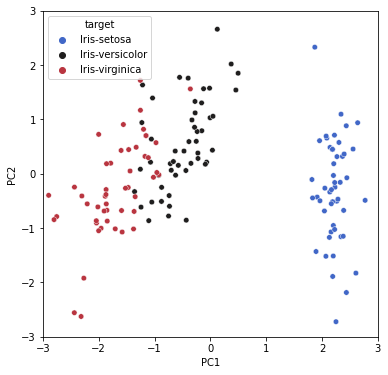

In [5]:
plt.figure(figsize = (6,6))
sb.scatterplot(data = pca_df, x='PC1', y='PC2', hue='target', s=30, palette='icefire')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

#### E-OBS gridded dataset

In [6]:
file = '/Users/miguel/Desktop/fisica_mates/cinque/tfg-PCA_extremes/rr_ens_mean_0.25deg_reg_v21.0e.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:    (longitude: 464, latitude: 201, time: 25567)
Coordinates:
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2019-12-31
Data variables:
    rr         (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.3 (http://code.zmaw.de/p...
    history:      Mon Jun 08 10:20:53 2020: cdo -z zip_2 mergetime rr_day_201...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.6.3 (http://code.zmaw.de/p...

In [7]:
# -----------------------------------------------------------------------------
# How to reduce the data size
# -----------------------------------------------------------------------------
small_region = ds['rr'].sel(longitude=slice(0, 20), latitude=slice(30, 40), time=slice('1980-04-12', '2010-05-03'))
low_resolution = ds['rr'].coarsen({'longitude': 4, 'latitude': 4}, boundary='trim').mean()

# -----------------------------------------------------------------------------
# How to create a 2d matrix
# -----------------------------------------------------------------------------
# dropna('x') is important to drop all grid cells which do not contain any data
# for example the open ocean when the data only contains continental rainfall
matrix_2d = small_region.stack(x=('latitude', 'longitude')).fillna(0).values

##### *Principal Component Analysis* for monthly precipitation over Europe

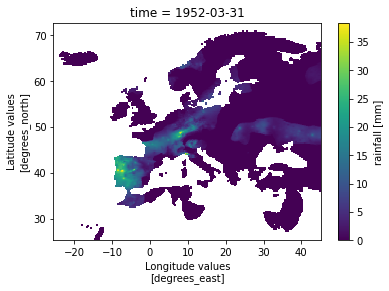

In [8]:
europe = ds.isel(latitude=slice(0, 190), longitude=slice(60, 343)) # region of Europe
europe_prcp = europe.isel(time=820).rr.plot() # precipitation over Europe during the day 31/03/1952
plt.show()

In [9]:
europe_prcp = low_resolution.resample({'time' : 'M'}).sum().stack(x=('latitude', 'longitude'))
europe_notnan_idx = europe_prcp.notnull().all(axis=0)
europe_prcp = europe_prcp[:, europe_notnan_idx]
assert(europe_prcp.isnull().any() == False)

pca = PCA(n_components=100)
projected = pca.fit_transform(europe_prcp.values)
eofs = pca.components_

da = xr.DataArray(eofs, dims=['mode', 'x'], coords={'x': europe_prcp.coords['x'], 'mode': range(1, eofs.shape[0] + 1)})
da = da.unstack().sortby(['latitude', 'longitude'])

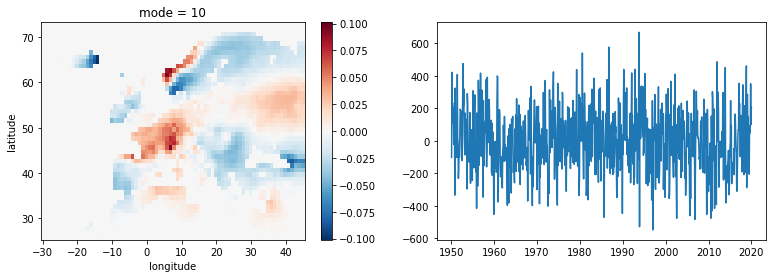

In [10]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 10
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1)
ax2.plot(europe_prcp.time, projected[:, mode - 1])
plt.show()

#### *Principal Component Analysis* and *Principal Component Analysis for Extremes* and Application to Spain Precipitation During Drop Cold Season

##### *Principal Component Analysis* and Application to Spain Monthly Precipitaton

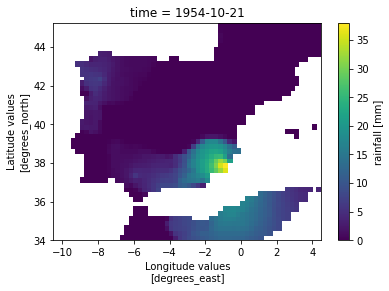

In [42]:
# Interesting precipitation days: 33, 772, 785, 806, 816, 819
spain = ds.isel(latitude=slice(35, 80), longitude=slice(120, 180)) # region of Spain
spain_prcp = spain.isel(time=1754).rr # precipitation over Spain during the day 30/04/1952
spain_prcp.plot()
plt.show()

In [43]:
spain_prcp = spain.resample({'time' : 'M'}).sum().stack(x=('latitude', 'longitude')).rr
spain_notnan_idx = spain_prcp.notnull().all(axis=0) # are we here avoiding all NaN?? or only just considering rows that have no NaN in its time series
spain_prcp = spain_prcp[:, spain_notnan_idx]
df_spain = spain_prcp.to_dataframe()

pca = PCA(n_components=100)
projected = pca.fit_transform(spain_prcp.values)
eofs = pca.components_

da = xr.DataArray(eofs, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, eofs.shape[0] + 1)})
da = da.unstack().sortby(['longitude', 'latitude'])

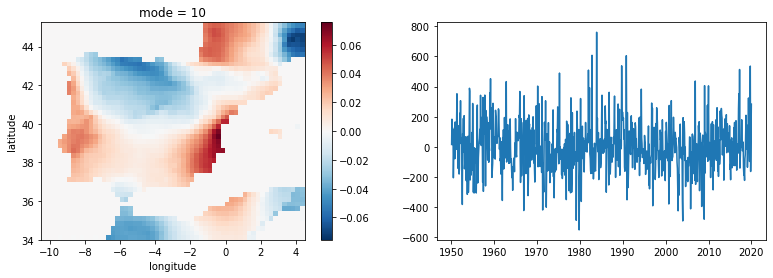

In [44]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 10
da.sel(mode=mode, latitude=slice(25, 73), longitude=slice(-30, 45)).plot(ax=ax1)
ax2.plot(spain_prcp.time, projected[:, mode - 1])
plt.show()

##### *Principal Component Analysis for Extremes* and Application to Spain Precipitaton during Cold Drop Season 

In [364]:
spain = ds.isel(latitude=slice(35, 80), longitude=slice(120, 180)) # region of Spain
spain_prcp = spain.stack(x=('latitude', 'longitude')).rr # daily precipitation over Spain
spain_notnan_idx = spain_prcp.notnull().all(axis=0)
spain_prcp = spain_prcp[:, spain_notnan_idx]

df_spain = spain_prcp.to_dataframe()
obs = pd.DataFrame(df_spain.droplevel(level=[1,2]).values.reshape(spain_prcp.time.shape[0], spain_prcp.x.shape[0]))

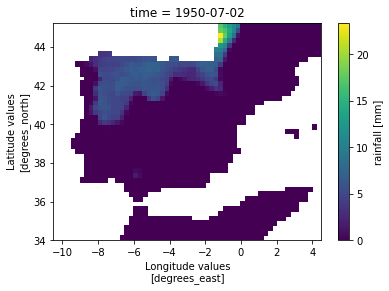

In [568]:
spain.isel(time=182).rr.plot()
plt.show()

In [ ]:
## Code for computing Tail Pairwise Dependence Matrix (TPDM)

## For Cold Drop (DANA) season data (July, August, September, October, November). Calculate TPDM, its eigen decomposition 
## and other quantities like principal components

dana_id = take_month(np.datetime_as_string(spain_prcp.time.values, timezone='UTC'), np.array([7, 8, 9, 10, 11]))
dana_date = spain_prcp.time.values[dana_id]
data_dana = obs.loc[dana_id, :] # Data corresponding to the drop cold season in Spain

dana_ave = ma(data_dana.values, k=3) # 3-day moving average
dana_smo = ECDF_smoothing(dana_ave, k=3) # ECDF smoothing
dana_tran = to_alpha_2(dana_smo) # Transfer the margins to have the same regular variation index: 2

sigma_dana = rw_Sigma(dana_tran) # Compute the TPDM
eigen_val, eigen_vec = np.linalg.eigh(sigma_dana) # Eigen decomposition of TPDM
idx = np.argsort(eigen_val)[::-1] # Sort eigenvalues and eigenvectors in ascending order
eigen_val = eigen_val[idx]
eigen_vec = eigen_vec[:, idx]
sign_eigenvectors = np.sign(eigen_vec[0, :])
eigen_vec *= sign_eigenvectors

U_dana = - eigen_vec # Basis vectors for PCA of TPDM
dana_tran_inv = inv_trans(dana_tran) # Inverse transformation
V_dana = pc(U_dana, dana_tran_inv) # Each column is a principal component
N = V_dana.shape[0]

##########################################################################################################
##########################################################################################################

## To plot basis vectors and reconstructions
long_dana = spain_prcp.unstack().longitude.shape[0]
lat_dana = spain_prcp.unstack().latitude.shape[0]

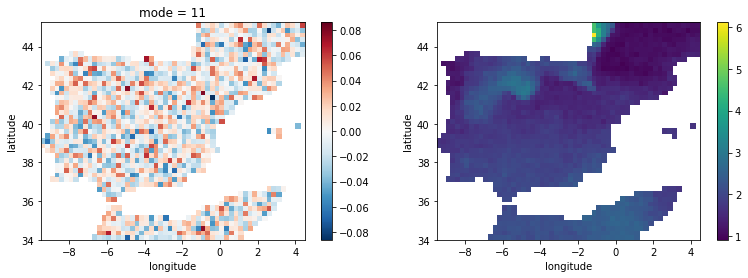

In [564]:
xU_dana = xr.DataArray(U_dana, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, U_dana.shape[0] + 1)}).unstack()
xV_dana = xr.DataArray(V_dana, dims=['mode', 'x'], coords={'x': spain_prcp.coords['x'], 'mode': range(1, V_dana.shape[0] + 1)}).unstack()

rec = reconstruct(V_dana, U_dana, 1149, 0)
xrec = xr.DataArray(rec, dims=['x'], coords={'x': spain_prcp.coords['x']}).unstack().sortby('longitude')

fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mode = 10
xU_dana.sortby('longitude').isel(mode=mode).plot(ax=ax1)
xrec.plot(ax=ax2)
plt.show()

#### *Principal Component Analysis* and *Principal Component Analysis for Extremes* and Application to U.S. Precipitation

In [235]:
import pyreadr

observations = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/obs.RData')
longitude = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/long.RData')
latitude = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/lat.RData')
timeseries = pyreadr.read_r('/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/time.RData')

observations = pd.Series(observations)
longitude = pd.Series(longitude)
latitude = pd.Series(latitude)
timeseries = pd.Series(timeseries)

obs = observations.values[0].astype(float)
long = longitude.values[0].astype(float)
lat = latitude.values[0].astype(float)
time = timeseries.values[0]

In [236]:
def near_PSD(A):
    C = (A + A.T) / 2
    eigen_val, eigen_vec = np.linalg.eigh(C)
    eigen_val[eigen_val < 0] = 0
    
    return np.matmul(np.matmul(eigen_vec, A), eigen_vec.T)

def take_month(time, Month):
    year = np.zeros(time.shape[0])
    month = np.zeros(time.shape[0])
    for i in range(time.shape[0]):
        ymd = time[i].rsplit("-", 2)
        year[i] = int(ymd[0])
        month[i] = int(ymd[1])
    
    return np.where(np.isin(month, Month))[0]

def take_month_year(time):
    year = np.zeros(time.shape[0])
    month = np.zeros(time.shape[0])
    for i in range(time.shape[0]):
        ymd = time[i].rsplit("-", 2)
        year[i] = int(ymd[0])
        month[i] = int(ymd[1])
    
    return month, year

def ma(x, k=3):
    res = np.zeros_like(x)
    aux = np.append(np.zeros((math.floor(k / 2), x.shape[1])) * np.nan, x, axis=0)
    for i in range(x.shape[0]):
        res[i, np.where(~np.isnan(x[i]))] = np.nanmean(aux[i:i+k, np.where(~np.isnan(x[i]))], axis=0)
        res[i, np.where(np.isnan(x[i]))] = np.nan
    
    return res

def ECDF_smoothing(x, k=3):
    each = np.zeros((x.shape[1], x.shape[0], k))
    for i in range(k):
        idx = np.arange(i, x.shape[0], k)
        for j in range(x.shape[1]):
            ni = np.sort(x[idx, j])[~np.isnan(np.sort(x[idx, j]))]
            if len(ni) > 0: each[j, :, i] = np.interp(x[:, j], ni, np.arange(1, ni.shape[0] + 1) / (ni.shape[0] + 1), left = 0, right = 1-1E-9)
            else: each[j, :, i] = np.nan
    
    return np.mean(each, axis = 2).T

def to_alpha_2(x):
    return np.sqrt(1 / - np.log(x))

def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    id_res = np.repeat(0, start.shape[0])
    for i in range(len(start)):
        temp = x.T.flatten()[start[i]:end[i] + 1]
        id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1
    return id_res

#def decls(x, th, k):
#    id_big = np.where(x.flatten() > th)[0]
#    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
#    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
#    idx = np.logical_and(np.arange(x.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
#    ext_prcp = np.repeat(x.flatten()[np.newaxis, :], repeats=idx.shape[0], axis=0)[idx]
#    cls_prcp = np.asarray(np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1]))
    
#    return list(map(np.argmax, cls_prcp)) + start

def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            r = np.sqrt(x[:, i] ** 2 + x[:, j] ** 2)
            w1 = x[:, i] / r
            w2 = x[:, j] / r
            idx = decls(r, th = np.nanquantile(r, u), k = 5)
            Sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2
    
    return Sigma

def trans(x):
    v = np.log(1 + np.exp(x))
    v[~np.isfinite(v)] = x[~np.isfinite(v)]
    v[x < -20] = np.exp(x[x < -20])
    
    return v

def inv_trans(v):
    x = np.log(np.exp(v) - 1)
    idx = np.logical_and(~np.isfinite(x), ~np.isnan(x), v > 1)
    x[idx] = v[idx]
    
    return x

def pc_one(i, U, invX):
    idxna = np.isnan(invX[i])
    
    return np.matmul(U[~idxna].T, invX[i, ~idxna])
    
def pc(U, invX):
    res = np.zeros_like(invX)
    for i in range(invX.shape[0]):
        res[i] = pc_one(i, U, invX)
    
    return res

def reconstruct(V, U, k, day):
    return trans(np.matmul(U[:, 0:k], V[day, 0:k]))

##### *Principal Component Analysis* and Application to U.S. Precipitation

In [237]:
#USA_notnan_idx = USA_prcp.notnull().all(axis=0) 
aso_id = take_month(time.values[:, 0], np.array([8, 9, 10]))
aso_date = time.values[aso_id, 0]
data_aso = obs.loc[aso_id, :].fillna(0) # Data corresponding to the Hurricane season

aso_ave = ma(data_aso.values, k=3) # 3-day moving average
aso_smo = ECDF_smoothing(aso_ave, k=3) # ECDF smoothing
aso_tran = to_alpha_2(aso_smo) # Transfer the margins to have the same regular variation index: 2

pca = PCA(n_components=1140) 
projected = pca.fit_transform(aso_tran)
eofs = pca.components_

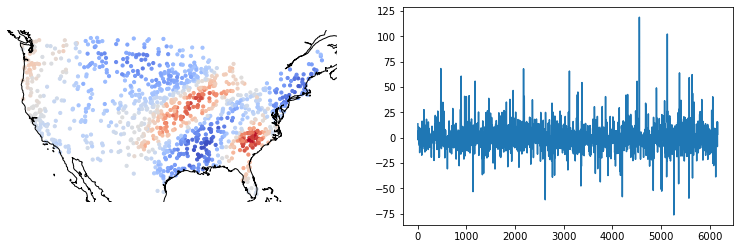

In [238]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121, projection=crs.Mercator())
ax2 = fig.add_subplot(122)

mode = 6
ax1.scatter(long.values, lat.values, c=eofs[mode, :], s=10, transform=crs.PlateCarree(), cmap='coolwarm')
ax1.coastlines()
ax1.axis('off')
ax2.plot(np.arange(projected.shape[0]), projected[:, mode - 1])
plt.show()

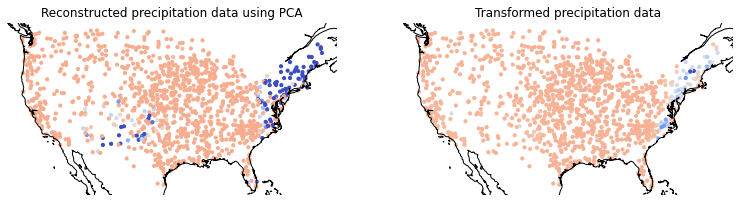

In [240]:
fig = plt.figure(figsize=(13, 4))
ax1 = fig.add_subplot(121, projection=crs.Mercator())
ax2 = fig.add_subplot(122, projection=crs.Mercator())

rec = pca.inverse_transform(pca.fit_transform(USA_prcp))
rec = pca.inverse_transform(pca.fit_transform(aso_tran))

ax1.scatter(long.values, lat.values, c=rec[4555, :], s=10, vmin= -30, vmax=70, transform=crs.PlateCarree(), cmap='coolwarm_r')
ax1.coastlines()
ax1.axis('off')
ax1.set_title("Reconstructed precipitation data using PCA")
ax2.scatter(long.values, lat.values, c=aso_tran[4555, :], s=10, vmin= -30, vmax=70, transform=crs.PlateCarree(), cmap='coolwarm_r')
ax2.coastlines()
ax2.axis('off')
ax2.set_title("Transformed precipitation data")
plt.show()

##### *Principal Component Analysis for Extremes* and Application to U.S Precipitation

In [241]:
## Code for computing Tail Pairwise Dependence Matrix (TPDM)

## For Hurricane season data (August, September, October). Calculate TPDM, its eigen decomposition and other quantities like principal components

aso_id = take_month(time.values[:, 0], np.array([8, 9, 10]))
aso_date = time.values[aso_id, 0]
data_aso = obs.loc[aso_id, :] # Data corresponding to the Hurricane season

aso_ave = ma(data_aso.values, k=3) # 3-day moving average
aso_smo = ECDF_smoothing(aso_ave, k=3) # ECDF smoothing
aso_tran = to_alpha_2(aso_smo) # Transfer the margins to have the same regular variation index: 2

sigma_aso = rw_Sigma(aso_tran) # Compute the TPDM
eigen_val, eigen_vec = np.linalg.eigh(sigma_aso) # Eigen decomposition of TPDM
idx = np.argsort(eigen_val)[::-1] # Sort eigenvalues and eigenvectors in ascending order
eigen_val = eigen_val[idx]
eigen_vec = eigen_vec[:, idx]
sign_eigenvectors = np.sign(eigen_vec[0, :])
eigen_vec *= sign_eigenvectors

U_aso = - eigen_vec # Basis vectors for PCA of TPDM
aso_tran_inv = inv_trans(aso_tran) # Inverse transformation
V_aso = pc(U_aso, aso_tran_inv) # Each column is a principal component
N = V_aso.shape[0]

##########################################################################################################
##########################################################################################################

## To plot basis vectors and reconstructions
long_aso = long.values[:, 0]
lat_aso = lat.values[:, 0]

## To plot time series of PCs with El Niño and La Niña and ENSO-medium periods added
enso = pd.read_csv('/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/enso.txt', sep='\t').set_index('Year')

conditions = [
    (enso.ASO <= -0.5),
    ((enso.ASO > -0.5) & (enso.ASO <= 0.5)),
    (enso.ASO > 0.5)]
values = ['low', 'medium', 'high']
enso['ENSO'] = np.select(conditions, values)

## Prepare year break for the time series of PC plot.
aso_mon, aso_yr = take_month_year(aso_date)

yr_st = np.repeat(0, len(enso.index) - 1) # 67: From 1951 - 2016
aso_yr_u = np.unique(aso_yr).astype(int)
for YR in range(len(enso.index) - 1):
    yr_st[YR] = np.where(aso_yr == aso_yr_u[YR])[0][0]

yr_bk = np.repeat(0, 3)
yri = 0
for YR in [1960, 1980, 2000]:
    yr_bk[yri] = np.where(aso_yr == YR)[0][0]
    yri += 1
yr_bk

mon_st = np.repeat(0, len(enso.index) - 1)
j = 0
for YR in range(len(enso.index) - 1):
    mon_st[j] = np.where((aso_yr == aso_yr_u[YR]) & (np.isin(aso_mon, np.array([8, 9, 10]))))[0][0]
    j += 1

enso['start'] = np.append(mon_st, np.nan)
enso['end'] = np.append(np.append(mon_st[1:] - 1, len(aso_yr)) - 1, np.nan)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135


In [242]:
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/python-aso_tran.RData", pd.DataFrame(aso_tran), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/python-sigma_aso.RData", pd.DataFrame(sigma_aso), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/python-U_aso.RData", pd.DataFrame(U_aso), compress="gzip")
pyreadr.write_rdata("/Users/miguel/desktop/fisica_mates/cinque/tfg-PCA_extremes/Yujing_RCode/python-V_aso.RData", pd.DataFrame(V_aso), compress="gzip")

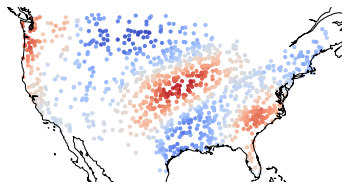

In [243]:
ax = plt.axes(projection=crs.Mercator())
plt.scatter(long_aso, lat_aso, c=U_aso[:, 6], s=10, transform=crs.PlateCarree(), cmap='coolwarm')
ax.coastlines()
ax.axis('off')
plt.show()

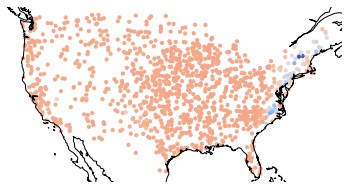

In [244]:
rec = reconstruct(V_aso, U_aso, 1140, 4555)

ax = plt.axes(projection=crs.Mercator())
plt.scatter(long_aso, lat_aso, c=rec, s=10, transform=crs.PlateCarree(), vmin= -30, vmax=80, cmap='coolwarm_r')
ax.coastlines()
ax.axis('off')
plt.show()

#### Trying to speed up the TPDM

In [521]:
import timeit

In [522]:
def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    id_res = np.repeat(0, start.shape[0])
    for i in range(len(start)):
        temp = x.T.flatten()[start[i]:end[i] + 1]
        id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1
    
    return id_res


def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            r = np.sqrt(x[:, i] ** 2 + x[:, j] ** 2)
            w1 = x[:, i] / r
            w2 = x[:, j] / r
            idx = decls(r, th = np.nanquantile(r, u), k = 5)
            Sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2
    
    return Sigma


def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    idx = np.logical_and(np.arange(x.T.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
    ext_prcp = x.T.flatten()[np.sum(idx * 1, axis=0).astype(bool)]
    cls_prcp = np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1])

    return list(map(np.nanargmax, cls_prcp)) + start


def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    r = np.sqrt(x.T[:, np.newaxis] ** 2 + x.T ** 2)
    w1 = x.T[:, np.newaxis] / r
    w2 = x.T[np.newaxis, :] / r
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            idx = decls(r[i,j], th = np.nanquantile(r[i,j], u), k = 5)
            Sigma[i, j] = np.nansum(w1[i,j,idx] * w2[i,j,idx]) / len(idx) * 2
    
    return Sigma

#### Just a small silly toy dataset

In [523]:
x = np.array([[6, 10, 3, np.nan, 5, 9, 11, 1, 1, 10],
              [12, 7, 1, 9, 4, 6, np.nan, 1, 11, 11],
              [1, 8, 1, 3, 12, 9, 10, 2, 7, 5],
              [8,  np.nan, 1, 3, 12,  10, 10, 2, 7, 5]]).astype(float) 
x = x.T
x

array([[ 6., 12.,  1.,  8.],
       [10.,  7.,  8., nan],
       [ 3.,  1.,  1.,  1.],
       [nan,  9.,  3.,  3.],
       [ 5.,  4., 12., 12.],
       [ 9.,  6.,  9., 10.],
       [11., nan, 10., 10.],
       [ 1.,  1.,  2.,  2.],
       [ 1., 11.,  7.,  7.],
       [10., 11.,  5.,  5.]])

In [524]:
def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    id_res = np.repeat(0, start.shape[0])
    for i in range(len(start)):
        temp = x.T.flatten()[start[i]:end[i] + 1]
        id_res[i] = np.where(temp == np.nanmax(temp))[0][0] + (start[i] + 1) - 1
    
    return id_res

decls(x, th=10, k=3)

array([ 6, 10, 18, 24, 34])

In [525]:
def decls(x, th, k):
    id_big = np.where(x.T.flatten() > th)[0]
    start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
    end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
    idx = np.logical_and(np.arange(x.T.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
    ext_prcp = x.T.flatten()[np.sum(idx * 1, axis=0).astype(bool)]
    cls_prcp = np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1])

    return list(map(np.nanargmax, cls_prcp)) + start

decls(x, th=5, k=3)

array([ 1,  6, 10, 18, 24, 34])

In [526]:
def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        print('\n')
        for j in range(x.shape[1]):
            r = np.sqrt(x[:, i] ** 2 + x[:, j] ** 2)
            print(r)
            w1 = x[:, i] / r
            w2 = x[:, j] / r
            idx = decls(r, th = np.nanquantile(r, u), k = 5)
            Sigma[i, j] = np.nansum(w1[idx] * w2[idx]) / len(idx) * 2
    
    return Sigma

rw_Sigma(x)



[ 8.48528137 14.14213562  4.24264069         nan  7.07106781 12.72792206
 15.55634919  1.41421356  1.41421356 14.14213562]
[13.41640786 12.20655562  3.16227766         nan  6.40312424 10.81665383
         nan  1.41421356 11.04536102 14.86606875]
[ 6.08276253 12.80624847  3.16227766         nan 13.         12.72792206
 14.86606875  2.23606798  7.07106781 11.18033989]
[10.                 nan  3.16227766         nan 13.         13.45362405
 14.86606875  2.23606798  7.07106781 11.18033989]


[13.41640786 12.20655562  3.16227766         nan  6.40312424 10.81665383
         nan  1.41421356 11.04536102 14.86606875]
[16.97056275  9.89949494  1.41421356 12.72792206  5.65685425  8.48528137
         nan  1.41421356 15.55634919 15.55634919]
[12.04159458 10.63014581  1.41421356  9.48683298 12.64911064 10.81665383
         nan  2.23606798 13.03840481 12.08304597]
[14.4222051          nan  1.41421356  9.48683298 12.64911064 11.66190379
         nan  2.23606798 13.03840481 12.08304597]


[ 6.082762

array([[1.        , 0.89773756, 0.99547511, 0.99547511],
       [0.89773756, 1.        , 0.90588235, 0.91447964],
       [0.99547511, 0.90588235, 1.        , 1.        ],
       [0.99547511, 0.91447964, 1.        , 1.        ]])

In [527]:
def rw_Sigma(x, u=0.80):
    Sigma = np.zeros((x.shape[1], x.shape[1]))
    r = np.sqrt(x.T[:, np.newaxis] ** 2 + x.T ** 2)
    print(r)
    w1 = x.T[:, np.newaxis] / r
    w2 = x.T[np.newaxis, :] / r
    for i in range(x.shape[1]):
        if i % 5 == 0: print(i)
        for j in range(x.shape[1]):
            idx = decls(r[i,j], th = np.nanquantile(r[i,j], u), k = 5)
            Sigma[i, j] = np.nansum(w1[i,j,idx] * w2[i,j,idx]) / len(idx) * 2
    
    return Sigma

rw_Sigma(x)

[[[ 8.48528137 14.14213562  4.24264069         nan  7.07106781
   12.72792206 15.55634919  1.41421356  1.41421356 14.14213562]
  [13.41640786 12.20655562  3.16227766         nan  6.40312424
   10.81665383         nan  1.41421356 11.04536102 14.86606875]
  [ 6.08276253 12.80624847  3.16227766         nan 13.
   12.72792206 14.86606875  2.23606798  7.07106781 11.18033989]
  [10.                 nan  3.16227766         nan 13.
   13.45362405 14.86606875  2.23606798  7.07106781 11.18033989]]

 [[13.41640786 12.20655562  3.16227766         nan  6.40312424
   10.81665383         nan  1.41421356 11.04536102 14.86606875]
  [16.97056275  9.89949494  1.41421356 12.72792206  5.65685425
    8.48528137         nan  1.41421356 15.55634919 15.55634919]
  [12.04159458 10.63014581  1.41421356  9.48683298 12.64911064
   10.81665383         nan  2.23606798 13.03840481 12.08304597]
  [14.4222051          nan  1.41421356  9.48683298 12.64911064
   11.66190379         nan  2.23606798 13.03840481 12.08304597

array([[1.        , 0.89773756, 0.99547511, 0.99547511],
       [0.89773756, 1.        , 0.90588235, 0.91447964],
       [0.99547511, 0.90588235, 1.        , 1.        ],
       [0.99547511, 0.91447964, 1.        , 1.        ]])

In [528]:
a = np.repeat(np.arange(0, 20, 1)[:, np.newaxis].T, 10, axis=0)
mask = a > 5

b = a.T[:, np.newaxis] + a.T
print(b.shape)
b.shape

c = (a**2).T @ a**2

(20, 20, 10)


In [529]:
x.T.flatten()

array([ 6., 10.,  3., nan,  5.,  9., 11.,  1.,  1., 10., 12.,  7.,  1.,
        9.,  4.,  6., nan,  1., 11., 11.,  1.,  8.,  1.,  3., 12.,  9.,
       10.,  2.,  7.,  5.,  8., nan,  1.,  3., 12., 10., 10.,  2.,  7.,
        5.])

In [530]:
k = 3; th = 5

id_big = np.where(x.T.flatten() > th)[0]
start = id_big[np.append(np.zeros(1), np.where(np.diff(id_big) >= k)[0] + 1).astype(int)]
end = np.append(id_big[np.where(np.diff(id_big) >= k)[0]], id_big[-1])
print
idx = np.logical_and(np.arange(x.T.flatten().shape[0]) >= start[:, np.newaxis], np.arange(x.flatten().shape[0]) <= end[:, np.newaxis])
print(idx)
ext_prcp = x.T.flatten()[np.sum(idx * 1, axis=0).astype(bool)]
cls_prcp = np.split(ext_prcp, np.cumsum(np.sum(idx, axis=1))[:-1])

list(map(np.nanargmax, cls_prcp)) + start

[[ True  True False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False  True  True  True
   True  True  True  True False False False False False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False False False  True  True  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [Fa

array([ 1,  6, 10, 18, 24, 34])